In [0]:
import pandas as pd
import os
import ast

import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import numpy as np

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd drive/"My Drive"/FMA_Music

/content/drive/My Drive/FMA_Music


### Load data

In [0]:
filepath = 'csv/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
tracks.head()

album                       ... track                 
         comments         date_created  ...  tags            title
track_id                                ...                       
2               0  2008-11-26 01:44:45  ...    []             Food
3               0  2008-11-26 01:44:45  ...    []     Electric Ave
5               0  2008-11-26 01:44:45  ...    []       This World
10              0  2008-11-26 01:45:08  ...    []          Freeway
20              0  2008-11-26 01:45:05  ...    []  Spiritual Level

[5 rows x 52 columns]

In [0]:
genres = {'Electronic':0,  'Folk':1,  'Pop' :2, 'Instrumental':3 }

In [0]:
keep_cols = [('set', 'split'),
('set', 'subset'),('track', 'genre_top'), ('track', 'genres')]

tracks = tracks[keep_cols]
tracks.head()

set             track           
             split  subset genre_top     genres
track_id                                       
2         training   small   Hip-Hop       [21]
3         training  medium   Hip-Hop       [21]
5         training   small   Hip-Hop       [21]
10        training   small       Pop       [10]
20        training   large       NaN  [76, 103]

### Look at the MFCC Features

In [0]:
filepath = 'csv/features.csv'
features = pd.read_csv(filepath, index_col=0,header=[0, 1, 2], skip_blank_lines=True )

In [0]:
mfcc = features['mfcc']
mfcc.head()

statistics   kurtosis                      ...       std                    
number             01        02        03  ...        18        19        20
track_id                                   ...                              
2            3.856789  1.541901  0.000816  ...  7.246555  7.077188  7.391859
3            4.296755  1.399977  0.112535  ...  7.285423  7.417791  8.777440
5            2.624517  2.415293  0.440233  ...  7.539753  8.452527  7.334442
10           5.076893  1.161854  2.095651  ...  6.928591  6.430473  6.186294
20          11.880132  4.085320  0.002655  ...  7.520811  7.098001  7.032246

[5 rows x 140 columns]

### PCA Analysis and Visualizations

#### 2 Genres

(106574,) (106574,) (106574,)


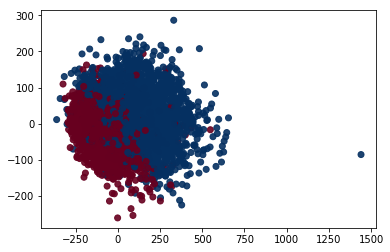

((5631, 2), (5631,))

In [0]:
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

print(small.shape, genre1.shape, genre2.shape)

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.9)
plt.show()
X.shape, y.shape

#### Multiple Genres

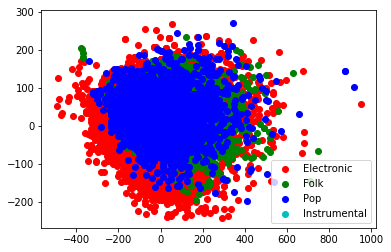

In [0]:
small = tracks['set', 'subset'] <= 'small'
#genre1 = tracks['track', 'genre_top'] == 'Rock'
#genre1 = tracks['track', 'genre_top'] == 'Instrument'
genre2 = tracks['track', 'genre_top'] == 'Instrument'
genre3 = tracks['track', 'genre_top'] == 'Folk'
genre4 = tracks['track', 'genre_top'] == 'Electronic'
genre5 = tracks['track', 'genre_top'] == 'Pop'

#print(small.shape, genre1.shape, genre2.shape)
X = features.loc[small & ( genre2| genre3| genre4|genre5), 'mfcc']
#X = features.loc[small & (genre1 | genre2| genre3| genre4|genre5), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & ( genre2| genre3| genre4|genre5), ('track', 'genre_top')]
#y = tracks.loc[small & (genre1 | genre2| genre3| genre4|genre5), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)



target_ids = range(len(genres))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
for i, c, label in zip(target_ids, colors, genres):
    plt.scatter(X[y == i, 0], X[y == i, 1], c=c, label=label)
 
plt.legend()
plt.show()


#plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.9)
#plt.show()
#X.shape, y.shape

### Break into train, validation and test

In [0]:
small = tracks['set', 'subset'] == 'small'
Instrumental = tracks[tracks[('track', 'genre_top')] == 'Rock'].index
International = tracks[tracks[('track', 'genre_top')] == 'International'].index
Experimental = tracks[tracks[('track', 'genre_top')] == 'Experimental'].index
Hip = tracks[tracks[('track', 'genre_top')] == 'Hip-Hop'].index
 
# Delete these row indexes from dataFrame
tracks.drop(Instrumental , inplace=True)
tracks.drop(International , inplace=True)
tracks.drop(Experimental , inplace=True)
tracks.drop(Hip , inplace=True)


train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = tracks.loc[small & train, ('track', 'genre_top')]
y_val = tracks.loc[small & val, ('track', 'genre_top')]
y_test = tracks.loc[small & test, ('track', 'genre_top')]

X_train_mfcc = features.loc[small & train, 'mfcc']
X_val_mfcc = features.loc[small & val, 'mfcc']
X_test_mfcc = features.loc[small & test, 'mfcc']


# X_train = pd.concat([X_train_mfcc, X_train_tonnetz], axis=1)
# X_val = pd.concat([X_val_mfcc, X_val_tonnetz], axis=1)

X_train = X_train_mfcc
X_val = X_val_mfcc

print(X_train_mfcc.shape)

print('{} training examples, {} testing examples'.format(y_train.size, y_val.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

(3200, 140)
3200 training examples, 400 testing examples
140 features, 4 classes


### Standardize Features and Encode Labels

In [0]:
#Shuffle training features
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

# Standardize features by removing the mean and scaling to unit variance.
scaler = skl.preprocessing.StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_mfcc)

In [0]:
## Label encode y - data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)
le.classes_

array(['Electronic', 'Folk', 'Instrumental', 'Pop'], dtype=object)

In [0]:
# X_train[:1]

In [0]:
y_train[:5]

array([3, 3, 0, 0, 3])

### Build models

In [0]:
x_tr=X_train
y_tr=y_train
x_cv=X_val
y_cv=y_val
x_te=X_test
y_te=y_test


scale = StandardScaler()
#x_scaled = scale.fit_transform(X)

scale.fit(x_tr)
scale.fit(x_cv)
scale.fit(x_te)
# Apply transform to both the training set and the test set.
train_sc = x_tr
cv_sc = x_cv
test_sc = x_te

In [0]:
#Knn
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance')

neigh.fit(train_sc, y_tr)
train_preds = neigh.predict(train_sc)
train_acc = np.sum(train_preds == y_tr)
train_acc = train_acc / len(y_tr)

cv_preds = neigh.predict(cv_sc)
cv_acc = np.sum(cv_preds == y_cv)
cv_acc = cv_acc / len(y_cv)
test_preds = neigh.predict(test_sc)
test_acc = np.sum(test_preds == y_te)
test_acc = test_acc / len(y_te);
print("KNN")
print('Train: ', train_acc, "\tCV: ", cv_acc, "\tTest: ", test_acc)

KNN
Train:  1.0 	CV:  0.5675 	Test:  0.46


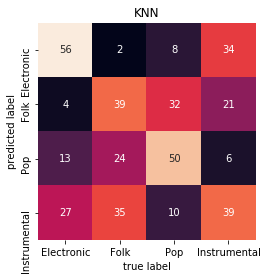

In [0]:
mat = confusion_matrix(y_te, test_preds)
#conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres.keys(),
            yticklabels=genres.keys())
plt.title('KNN')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
#Svm
svm = SVC(C=2, kernel='rbf', gamma="scale")
#cv_scores = cross_val_score(svm, X, y)
#print(cv_scores)
#print("SVM: cv_scores mean:{}".format(np.mean(cv_scores)))
svm.fit(train_sc,y_tr)
train_preds = svm.predict(train_sc)
train_acc = np.sum(train_preds == y_tr)
train_acc = train_acc / len(y_tr)

#svm.fit(cv_sc,y_cv)
cv_preds = svm.predict(cv_sc)
cv_acc = np.sum(cv_preds == y_cv)
cv_acc = cv_acc / len(y_cv)

#svm.fit(test_sc,y_te)
test_preds = svm.predict(test_sc)
test_acc = np.sum(test_preds == y_te)
test_acc = test_acc / len(y_te);
print("SVM:")
print('Train: ', train_acc, "\tCV: ", cv_acc, "\tTest: ", test_acc)


SVM:
Train:  0.9121875 	CV:  0.65 	Test:  0.5425


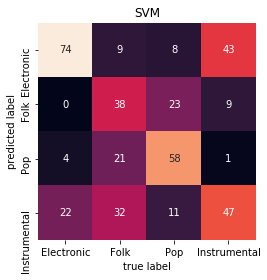

In [0]:
mat = confusion_matrix(y_te, test_preds)
#conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres.keys(),
            yticklabels=genres.keys())
plt.title('SVM')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
lr = LogisticRegression(penalty='l2', C = 1)
lr.fit(train_sc,y_tr)
train_preds = lr.predict(train_sc)
train_acc = np.sum(train_preds == y_tr)
train_acc = train_acc / len(y_tr)

cv_preds = lr.predict(cv_sc)
cv_acc = np.sum(cv_preds == y_cv)
cv_acc = cv_acc / len(y_cv)

test_preds = lr.predict(test_sc)
test_acc = np.sum(test_preds == y_te)
test_acc = test_acc / len(y_te);print
print("LR")
('Train: ', train_acc, "\tCV: ", cv_acc, "\tTest: ", test_acc)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LR


('Train: ', 0.7203125, '\tCV: ', 0.6575, '\tTest: ', 0.495)

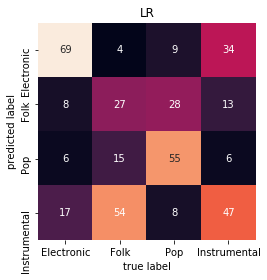

In [0]:
mat = confusion_matrix(y_te, test_preds)
#conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres.keys(),
            yticklabels=genres.keys())
plt.title('LR')
plt.xlabel('true label')
plt.ylabel('predicted label');

In [0]:
cart = DecisionTreeClassifier(criterion = 'entropy')
cart.fit(train_sc,y_tr)
train_preds = cart.predict(train_sc)
train_acc = np.sum(train_preds == y_tr)
train_acc = train_acc / len(y_tr)

#svm.fit(cv_sc,y_cv)
cv_preds = cart.predict(cv_sc)
cv_acc = np.sum(cv_preds == y_cv)
cv_acc = cv_acc / len(y_cv)

#svm.fit(test_sc,y_te)
test_preds = cart.predict(test_sc)
test_acc = np.sum(test_preds == y_te)
test_acc = test_acc / len(y_te);
print("DT")
print('Train: ', train_acc, "\tCV: ", cv_acc, "\tTest: ", test_acc)

DT
Train:  1.0 	CV:  0.5 	Test:  0.4025


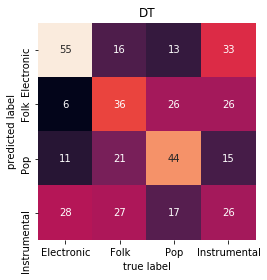

In [0]:
mat = confusion_matrix(y_te, test_preds)
#conf_mat_normalized = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=genres.keys(),
            yticklabels=genres.keys())
plt.title('DT')
plt.xlabel('true label')
plt.ylabel('predicted label');